# Final Project INF-475
## Wildfire Spreading: Weather forecasting
### Daniel San Martín

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot

In [21]:
FtoC = lambda t: (t - 32) * (5 / 9)

In [22]:
df = pd.read_csv('data/CDO5622797695969.csv') # Read data
df.rename(columns=lambda i: i.strip(), inplace=True) # Clean white spaces in header
df.head() # Show some values

,STN---,WBAN,YEARMODA,TEMP,,DEWP,.1,SLP,.2,STP,...,WDSP,.5,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,Unnamed: 22
0,859212,99999,20091031,57.7,7,52.8,7,9999.9,0,9999.9,...,23.1,7,999.9,999.9,59.0*,55.4*,0.00I,999.9,100000,NaN
1,859212,99999,20091101,58.1,8,52.7,8,9999.9,0,9999.9,...,4.7,8,8.0,999.9,60.8*,55.4*,0.00I,999.9,0,NaN
2,859212,99999,20091106,64.4,4,44.6,4,9999.9,0,9999.9,...,14.0,4,15.9,999.9,66.2*,62.6*,0.00I,999.9,0,NaN
3,859212,99999,20091107,55.0,5,43.2,5,9999.9,0,9999.9,...,7.6,5,14.0,999.9,62.6*,51.8*,0.00I,999.9,0,NaN
4,859212,99999,20091108,58.2,7,47.2,7,9999.9,0,9999.9,...,8.4,7,15.0,999.9,66.2*,51.8*,0.00I,999.9,0,NaN


In [104]:
df.describe()

,STN---,WBAN,YEARMODA,TEMP,,DEWP,.1,SLP,.2,STP,.3,VISIB,.4,WDSP,.5,MXSPD,GUST,SNDP,FRSHTT,Unnamed: 22
count,2126.0,2126.0,2.126000e+03,2126.000000,2126.000000,2126.000000,2126.000000,2.126000e+03,2126.0,2.126000e+03,2126.0,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2.126000e+03,2126.000000,0.0
mean,859212.0,99999.0,2.013885e+07,57.099718,22.209313,50.595390,22.195673,9.999900e+03,0.0,9.999900e+03,0.0,157.359548,15.719191,5.504798,22.127940,16.388993,982.992239,9.999000e+02,19901.241769,NaN
std,0.0,0.0,2.998035e+04,5.458795,2.862977,4.814197,2.869605,1.073456e-10,0.0,1.073456e-10,0.0,357.997705,8.385684,37.430917,3.025165,74.198387,127.076389,3.900376e-11,39431.717691,NaN
min,859212.0,99999.0,2.009103e+07,42.000000,4.000000,29.700000,4.000000,9.999900e+03,0.0,9.999900e+03,0.0,0.100000,0.000000,0.000000,0.000000,2.900000,20.000000,9.999000e+02,0.000000,NaN
25%,859212.0,99999.0,2.011050e+07,53.100000,21.000000,47.400000,21.000000,9.999900e+03,0.0,9.999900e+03,0.0,5.000000,10.000000,3.000000,21.000000,8.900000,999.900000,9.999000e+02,0.000000,NaN
50%,859212.0,99999.0,2.015081e+07,56.900000,23.000000,50.700000,23.000000,9.999900e+03,0.0,9.999900e+03,0.0,6.100000,19.000000,3.900000,23.000000,9.900000,999.900000,9.999000e+02,0.000000,NaN
75%,859212.0,99999.0,2.017012e+07,61.100000,24.000000,54.200000,24.000000,9.999900e+03,0.0,9.999900e+03,0.0,6.300000,22.000000,5.000000,24.000000,13.000000,999.900000,9.999000e+02,10000.000000,NaN
max,859212.0,99999.0,2.018073e+07,76.900000,24.000000,64.700000,24.000000,9.999900e+03,0.0,9.999900e+03,0.0,999.900000,24.000000,999.900000,24.000000,999.900000,999.900000,9.999000e+02,110000.000000,NaN


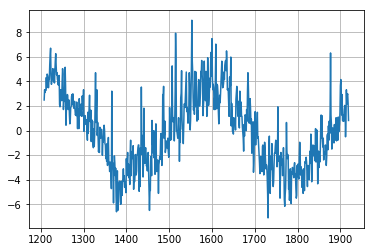

In [129]:
year_start = int(df.index[df['YEARMODA'] == 20160101][0])
year_end = int(df.index[df['YEARMODA'] == 20171231][0])
train = df.loc[year_start:year_end+1] # Get data 2016 - 2017
test = df.loc[year_end:] # Test data from 2018
tmp = FtoC(train['TEMP']) # Transform to celsius
x_train = tmp - tmp.mean() # Center data
x_train.plot()
plt.grid(True)
plt.show()

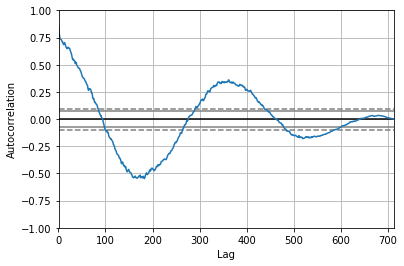

In [130]:
pd.plotting.autocorrelation_plot(x_train)
plt.show()

/home/dsanmartin/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


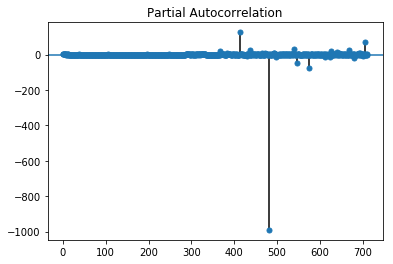

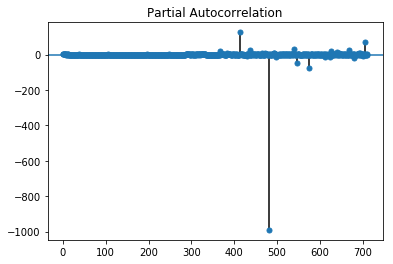

In [131]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(x_train)

In [133]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [134]:
error = evaluate_arima_model(x_train.values, (1, 0, 1))

In [136]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [137]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(x_train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=9.250
ARIMA(0, 0, 1) MSE=4.235
ARIMA(0, 0, 2) MSE=3.370
ARIMA(0, 1, 0) MSE=2.157
ARIMA(0, 1, 1) MSE=1.953
ARIMA(0, 1, 2) MSE=1.728
ARIMA(0, 2, 0) MSE=5.165
ARIMA(0, 2, 1) MSE=2.167
ARIMA(1, 0, 0) MSE=2.049
ARIMA(1, 0, 1) MSE=1.932
ARIMA(1, 0, 2) MSE=1.729
ARIMA(1, 1, 0) MSE=2.086
ARIMA(1, 1, 1) MSE=1.739
ARIMA(1, 1, 2) MSE=1.733
ARIMA(1, 2, 0) MSE=4.046
ARIMA(2, 0, 0) MSE=2.010
ARIMA(2, 0, 2) MSE=1.731
ARIMA(2, 1, 0) MSE=1.908
ARIMA(2, 1, 1) MSE=1.733
ARIMA(2, 2, 0) MSE=3.118
ARIMA(4, 0, 0) MSE=1.876
ARIMA(4, 0, 1) MSE=1.739
ARIMA(4, 1, 0) MSE=1.854
ARIMA(4, 1, 1) MSE=1.736
ARIMA(4, 1, 2) MSE=1.738
ARIMA(4, 2, 0) MSE=2.627
ARIMA(6, 0, 0) MSE=1.827
ARIMA(6, 0, 1) MSE=1.737
ARIMA(6, 1, 0) MSE=1.823
ARIMA(6, 1, 1) MSE=1.747
ARIMA(6, 1, 2) MSE=1.747
ARIMA(6, 2, 0) MSE=2.315
ARIMA(8, 0, 0) MSE=1.824
ARIMA(8, 0, 1) MSE=1.746
ARIMA(8, 1, 0) MSE=1.787
ARIMA(8, 1, 1) MSE=1.738
ARIMA(8, 2, 0) MSE=2.300
ARIMA(10, 0, 0) MSE=1.781
ARIMA(10, 0, 1) MSE=1.783
ARIMA(10, 1, 0) MSE=1.7

In [114]:
from statsmodels.tsa.arima_model import ARIMA

In [138]:
model = ARIMA(x_train, order=(0, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.TEMP   No. Observations:                  711
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1264.727
Method:                       css-mle   S.D. of innovations              1.432
Date:                Sat, 28 Jul 2018   AIC                           2537.455
Time:                        23:07:37   BIC                           2555.721
Sample:                             1   HQIC                          2544.511
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0024      0.012     -0.201      0.841      -0.026       0.021
ma.L1.D.TEMP    -0.4783      0.035    -13.856      0.000      -0.546      -0.411
ma.L2.D.TEMP    -0.2975      0.035     -8.51

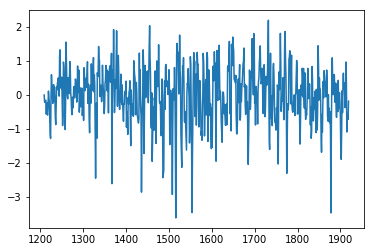

In [139]:
model_fit.fittedvalues.plot()

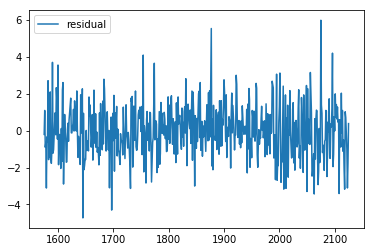

In [124]:
residuals = pd.DataFrame(model_fit.resid, columns=['residual'])
residuals.plot()
plt.legend()
plt.show()

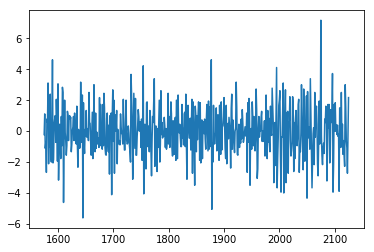

In [125]:
plt.plot(model_fit.resid + model_fit.fittedvalues)
plt.show()

In [126]:
model_fit.plot_diagnostics(figsize=(20, 14))
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_diagnostics'